# Modeling Wine Preferences with DataBricks

In this notebook, we'll be using PySpark and Databricks Runtime for Machine Learning to predict the quality of Portugese "Vinho Verde" wine based on the wine's physiochemical properties.

[Inspired by the awesome work of Cortez et al.](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub)

## Importing Data

In [0]:
%sh wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

--2021-04-06 14:36:03-- https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

 0K .......... .......... .......... .......... .......... 60% 845K 0s
 50K .......... .......... .......... .. 100% 1.14M=0.09s

2021-04-06 14:36:03 (946 KB/s) - ‘winequality-red.csv’ saved [84199/84199]

In [0]:
%sh wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2021-04-06 14:36:22-- https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

 0K .......... .......... .......... .......... .......... 19% 850K 0s
 50K .......... .......... .......... .......... .......... 38% 902K 0s
 100K .......... .......... .......... .......... .......... 58% 38.4M 0s
 150K .......... .......... .......... .......... .......... 77% 69.5M 0s
 200K .......... .......... .......... .......... .......... 96% 1.81M 0s
 250K ........ 100% 152M=0.1s

2021-04-06 14:36:22 (1.76 MB/s) - ‘winequality-white.csv’ saved [264426/264426]

In [0]:
import pandas as pd

wine_data_path_red = "file:/databricks/driver/winequality-red.csv"
wine_data_path_white = "file:/databricks/driver/winequality-white.csv"

white_wine = pd.read_csv(wine_data_path_red, sep=';')
red_wine = pd.read_csv(wine_data_path_white, sep=';')

In [0]:
import numpy as np

# Merge the two dataframes into a single dataset, with a new binary feature
# "is_red" denoting whether the wine is red or white.

red_wine['is_red'] = 1
white_wine['is_red'] = 0

# Concatenate the red_wine and white_wine dataframes
data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

## Data Visualization
Before training the model, explore the dataset with Seaborn and Matplotlib

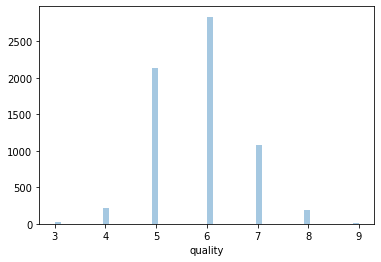

In [0]:
# Plot histogram of the dependant variable, quality
import seaborn as sns
sns.distplot(data.quality, kde=False);

In [0]:
# Define wine as high quality if it has quality >= 7
high_quality = data.quality >= 7
data.quality = high_quality

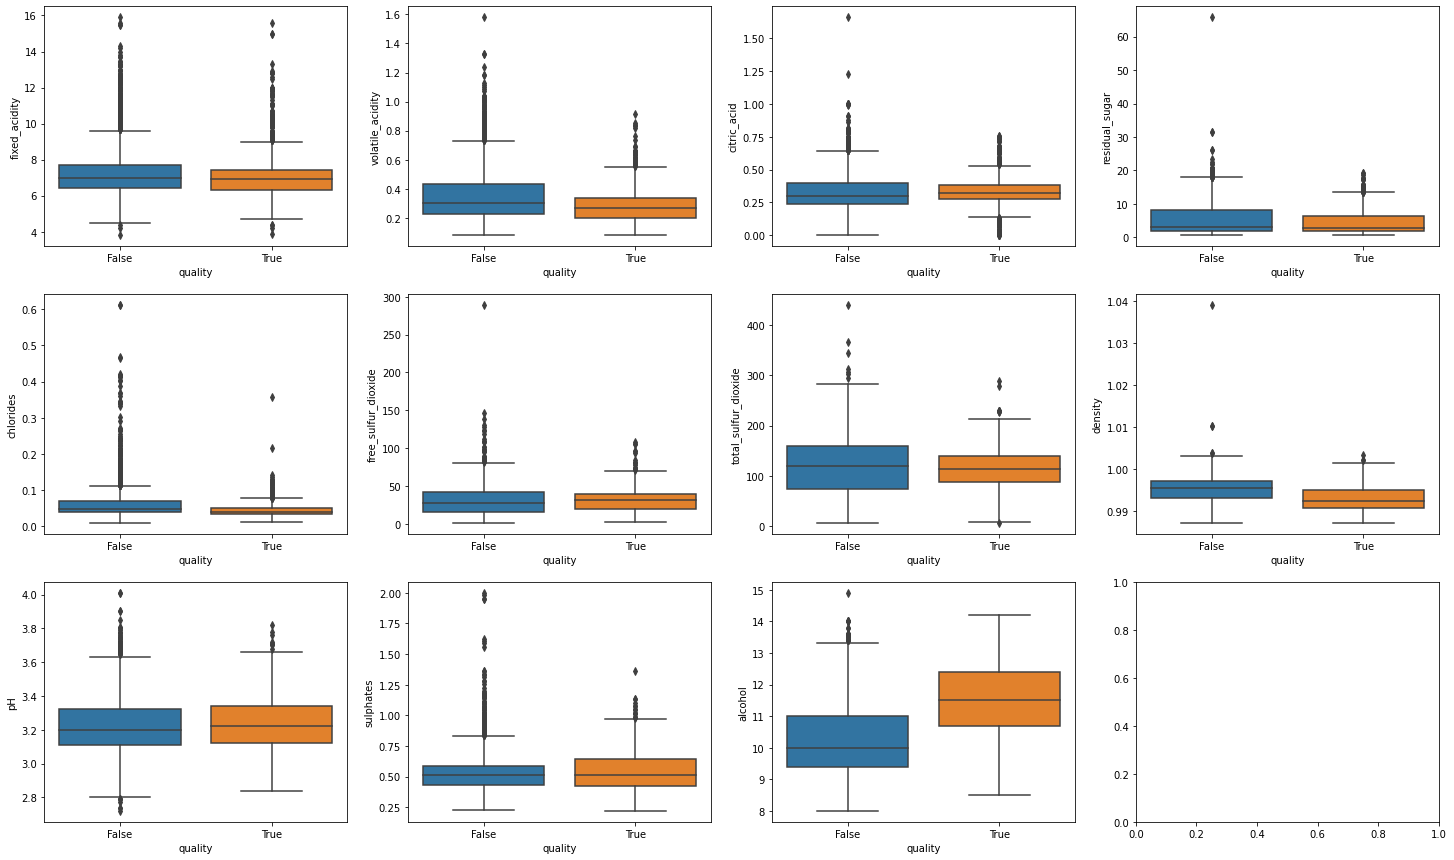

In [0]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]: 
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality. 

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocessing Data
Check for missing values and split the data into training and validation sets

In [0]:
data.isna().any()

Out[48]: fixed_acidity False
volatile_acidity False
citric_acid False
residual_sugar False
chlorides False
free_sulfur_dioxide False
total_sulfur_dioxide False
density False
pH False
sulphates False
alcohol False
quality False
is_red False
dtype: bool

There are no missing values

In [0]:
from sklearn.model_selection import train_test_split

train, target = data.drop(columns='quality'), data.quality

X_train, X_test, y_train, y_test = train_test_split(train, target)

## Building a Baseline Model
Since the output is binary, and there may be interactions between multiple variables, the task seems well suited to a random forest classifier.

In [0]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Fit a RandomForestClassifier with n_estimators
n_estimators = 10
model = RandomForestClassifier(n_estimators=n_estimators,
                              random_state=np.random.RandomState(314))
model.fit(X_train, y_train)

# predict_proba return [prob_negative, prob_positive]
predictions_test = model.predict_proba(X_test)[:,1]
# Get the roc_auc_score using y_test and predictions_test
auc_score = roc_auc_score(y_test, predictions_test)
auc_score

Out[68]: 0.8909213572731873

Examine the learned feature importances output by the model as a sanity-check

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_,
                      index=X_train.columns.tolist(),
                      columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

Out[69]:

,importance
alcohol,0.165527
density,0.113498
volatile_acidity,0.087435
citric_acid,0.087373
total_sulfur_dioxide,0.085246
chlorides,0.081389
free_sulfur_dioxide,0.080469
sulphates,0.080047
residual_sugar,0.077130
pH,0.076126


As illustrated by the boxplots shown previously, both alcohol and density are important in predicting quality.